<a href="https://colab.research.google.com/github/rexian/ML/blob/main/ML/agenticai/langgraph/Multi_agent_llm_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install -q -U langgraph

In [26]:
import os
import getpass
import functools
import operator
from typing import TypedDict, Annotated, List

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import Tool
from langgraph.graph import StateGraph, END

In [27]:
if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for GOOGLE AI Endpoints: ")

In [28]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)

In [29]:
def google_search(query: str) -> str:
    """
    Simulates a web search and returns a predefined response based on the query.
    In a real application, this would integrate with a web search API (e.g., Google Search API).
    """
    print(f"Simulating search for: '{query}'...")
    if "LangGraph" in query.lower() and "multi-agent" in query.lower():
        return "LangGraph is a framework for building stateful, multi-actor applications with LLMs, enabling complex workflows and agentic behaviors."
    elif "multi-agent pipeline" in query.lower():
        return "A multi-agent pipeline involves multiple AI agents collaborating sequentially or in parallel to achieve a larger goal, often managed by an orchestration framework."
    elif "large language models" in query.lower() or "llm" in query.lower():
        return "Large Language Models (LLMs) are deep learning models trained on vast amounts of text data, capable of understanding and generating human-like text."
    else:
        return "No specific information found for your query in our dummy database. Try a more specific query related to AI agents or LangGraph."

In [30]:
search_tool = Tool(
    name="search",
    func=google_search,
    description="Useful for searching information on the internet about AI, LangGraph, or multi-agent systems."
)
llm_with_tools = llm.bind_tools([search_tool])

In [31]:
class AgentState(TypedDict):
    query: str
    research_results: Annotated[List[str], operator.add]
    summary: str
    messages: Annotated[List[HumanMessage | ToolMessage], operator.add]

In [32]:
def researcher_node(state: AgentState) -> AgentState:
    """
    The Researcher agent node.
    """
    print(" RESEARCHER AGENT ")
    current_query = state["query"]
    messages = state["messages"]

    if not state["research_results"]:
        llm_response = llm_with_tools.invoke(
            messages + [HumanMessage(content=f"Based on the main query '{current_query}', what specific information should I search for to gather relevant details?")]
        )

        tool_calls = llm_response.tool_calls

        if tool_calls and tool_calls[0].name == "search":
            search_term = tool_calls[0].args.get("query", current_query)
            print(f"Researcher found a search tool call: {search_term}")
            tool_output = search_tool.invoke({"query": search_term})
            messages.append(ToolMessage(tool_output, tool_call_id=tool_calls[0].id))
            state["research_results"].append(tool_output)
            print(f"Research results added: {tool_output[:50]}...")
        else:
            tool_output = search_tool.invoke({"query": current_query})
            messages.append(ToolMessage(tool_output, tool_call_id="fallback_search_id"))
            state["research_results"].append(tool_output)
            print(f"Research results added (fallback): {tool_output[:50]}...")

    else:
        print("Research already performed. Moving to next stage.")
    return {"research_results": state["research_results"], "messages": messages}

In [33]:
def summarizer_node(state: AgentState) -> AgentState:
    """
    The Summarizer agent node.
    """
    print(" SUMMARIZER AGENT ")
    all_research_results = "\n\n".join(state["research_results"])
    messages = state["messages"]

    if not all_research_results:
        summary = "No research results available to summarize."
        print(summary)
    else:
        summary_prompt = (
            f"Please provide a concise summary of the following information. "
            f"Focus on key concepts related to multi-agent pipelines and LangGraph:\n\n"
            f"{all_research_results}"
        )

        summary_response = llm.invoke(messages + [HumanMessage(content=summary_prompt)])
        summary = summary_response.content
        print(f"Generated summary: {summary[:100]}...") # Print a snippet

    state["summary"] = summary
    messages.append(HumanMessage(content=f"Final Summary: {summary}"))
    return {"summary": summary, "messages": messages}

In [34]:
def should_continue(state: AgentState) -> str:
    """
    Determines whether the pipeline should continue with research or proceed to summarization.
    """
    print(" DECIDING NEXT STEP ")
    if state["research_results"]:
        print("Research results found. Proceeding to summarize.")
        return "summarize"
    else:
        return "research"

In [37]:
# Initialize the StateGraph with the defined AgentState
workflow = StateGraph(AgentState)

# Add the nodes to the workflow
workflow.add_node("researcher", researcher_node)
workflow.add_node("summarizer", summarizer_node)

# Set the entry point for the graph
workflow.set_entry_point("researcher")

workflow.add_conditional_edges(
    "researcher",
    should_continue,
    {
        "research": "researcher",  # In this simple setup, this path might not be taken often
        "summarize": "summarizer",
    },
)

workflow.add_edge("summarizer", END)
app = workflow.compile()

# Run the Pipeline

# Define the initial input for the pipeline
initial_inputs = {
    "query": "Explain multi-agent pipelines and LangGraph.",
    "research_results": [],
    "summary": "",
    "messages": [HumanMessage(content="Initial request: Explain multi-agent pipelines and LangGraph.")]
}

print(" STARTING MULTI-AGENT PIPELINE ")
final_state = app.invoke(initial_inputs)

print(" PIPELINE EXECUTION COMPLETE ")
print(" FINAL STATE ")
print(f"Original Query: {final_state['query']}")
print(f"Accumulated Research Results: {final_state['research_results']}")
print(f"Final Summary: {final_state['summary']}")
print(" MESSAGE HISTORY ")
for msg in final_state['messages']:
    if isinstance(msg, HumanMessage):
        print(f"Human: {msg.content}")
    elif isinstance(msg, ToolMessage):
        print(f"Tool Output (from {msg.tool_call_id}): {msg.content}")
    else:
        print(f"Other Message: {msg}")

 STARTING MULTI-AGENT PIPELINE 
 RESEARCHER AGENT 
Simulating search for: 'Explain multi-agent pipelines and LangGraph.'...
Research results added (fallback): A multi-agent pipeline involves multiple AI agents...
 DECIDING NEXT STEP 
Research results found. Proceeding to summarize.
 SUMMARIZER AGENT 
Generated summary: Multi-agent pipelines involve multiple AI agents working together, either sequentially or in paralle...
 PIPELINE EXECUTION COMPLETE 
 FINAL STATE 
Original Query: Explain multi-agent pipelines and LangGraph.
Accumulated Research Results: ['A multi-agent pipeline involves multiple AI agents collaborating sequentially or in parallel to achieve a larger goal, often managed by an orchestration framework.', 'A multi-agent pipeline involves multiple AI agents collaborating sequentially or in parallel to achieve a larger goal, often managed by an orchestration framework.']
Final Summary: Multi-agent pipelines involve multiple AI agents working together, either sequentially or 

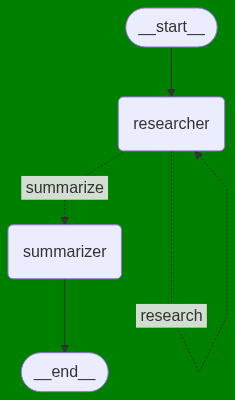

In [38]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
import nest_asyncio

nest_asyncio.apply()

try:
    display(Image(app.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.API,
            background_color="green",
            padding=10,
        )))
except Exception:
    # This requires some extra dependencies and is optional
    pass